In [1]:
import csv
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
import json
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import pickle
from joblib import dump

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kostas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# list of capec  most frequent words
# freq_capec_words = ["attack", "attacker", "attacks", "attackers", "adversary", "target", "targets", "system",
#                     "systems","application", "applications", "api", "information", "access", "server", "servers", "malicious",
#                     "service", "message", "content", "request", "resource", "victim", "client", "exploit", "often",
#                    "an", "the", "this", "may", "user", "data", "file", "web", "type", "used", "port", "code", "use", "in", 
#                     "software", "password", "input", "credential", "network", "response", "packet", "one", "sensitive", "within",
#                     "device", "control", "example", "able", "cause", "result", "an", "the", "this", "in", "file"]

freq_capec_words = ['attack', 'adversary', 'attacker', 'an', 'system', 'target', 'application', 'the', 'information', 'this', 'may', 'user', 'data', 'access', 'service', 'file', 'server', 'malicious', 'message', 'web', 'type', 'used', 'content', 'port', 'request', 'code', 'use', 'victim', 'resource', 'in', 'client', 'exploit', 'often', 'software', 'password', 'input', 'credential', 'network', 'response', 'packet', 'one', 'sensitive', 'within', 'device', 'control', 'example', 'able', 'cause', 'result', 'operating']
#freq_capec_words = ['file', 'browser', 'protocol', 'number', 'tcp', 'service', 'message', 'host', 'credential', 'script', 'resource', 'authentication', 'functionality', 'site', 'request', 'technique', 'key', 'domain', 'configuration', 'http', 'via', 'component', 'value', 'filter', 'session', 'character', 'behavior', 'port', 'command', 'leverage', 'scan', 'error', 'password', 'ip', 'open', 'perform', 'name', 'scanning', 'remote', 'purpose', 'gain', 'communication', 'allows', 'location', 'privilege', 'would', 'state', 'when', 'injection', 'allow', 'known', 'lock', 'firewall', 'icmp', 'specific', 'mechanism', 'form', 'address', 'take', 'time']


In [3]:
def get_top_n_words(corpus, n=None):
    # receives a list of sentences
    # the most frequent words with their number of appearances
    vec = CountVectorizer(max_df=0.1).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [4]:
# function for preprocessing list of text sentences
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in en_stop and word not in freq_capec_words]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token not in freq_capec_words and token not in en_stop:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(lemmatizer.lemmatize(token))
   

    return filtered_tokens


In [5]:
# function for printing cluster centroids
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # print("\nTopic #%d:" % topic_idx)
        topici = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics[topic_idx] = topici

    with open('lda-topics.txt', 'w') as outfile:
        json.dump(topics, outfile)


In [6]:
# read csv files and lemmatize
stem_ls = []
data_lemmatized = []
with open('1000.csv', encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            # print("ID=", row[0])
            # print("Name=", row[1])
            # print("Abstraction=", row[2])
            # print("Status=", row[3])
            # print("Description=", row[4])
            desc = row[4]
            toks = tokenize_and_stem(desc)
            fullstring = ' '.join(toks)
            stem_ls.append(fullstring)
            data_lemmatized.append(toks)

Column names are 'ID, Name, Abstraction, Status, Description, Alternate Terms, Likelihood Of Attack, Typical Severity, Related Attack Patterns, Execution Flow, Prerequisites, Skills Required, Resources Required, Indicators, Consequences, Mitigations, Example Instances, Related Weaknesses, Taxonomy Mappings, Notes


In [7]:
ls_common_words = []
common_words = get_top_n_words(stem_ls, 50)
for word, freq in common_words:
    print(word, freq)
    ls_common_words.append(word)
print(ls_common_words)

file 90
browser 88
protocol 86
number 86
tcp 86
service 85
message 83
host 82
credential 81
script 81
resource 79
authentication 75
functionality 74
site 74
request 74
technique 74
key 71
domain 70
configuration 69
http 69
via 69
component 66
value 65
filter 64
session 63
character 63
behavior 63
port 62
command 61
leverage 60
scan 60
error 59
password 59
ip 59
open 59
perform 58
name 57
scanning 57
remote 56
purpose 56
gain 55
communication 55
allows 55
location 55
privilege 54
would 54
state 54
when 54
injection 53
allow 53
['file', 'browser', 'protocol', 'number', 'tcp', 'service', 'message', 'host', 'credential', 'script', 'resource', 'authentication', 'functionality', 'site', 'request', 'technique', 'key', 'domain', 'configuration', 'http', 'via', 'component', 'value', 'filter', 'session', 'character', 'behavior', 'port', 'command', 'leverage', 'scan', 'error', 'password', 'ip', 'open', 'perform', 'name', 'scanning', 'remote', 'purpose', 'gain', 'communication', 'allows', 'locatio

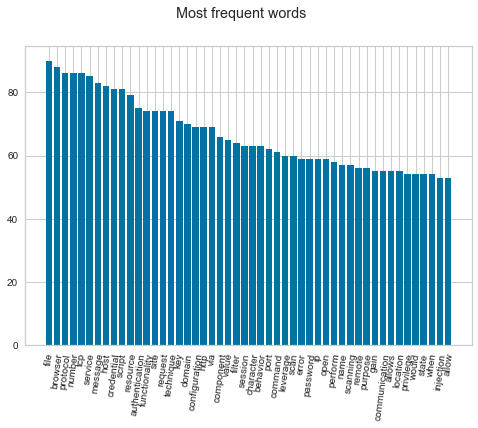

In [8]:
import matplotlib.pyplot as plt

words = [i[0] for i in common_words]
appears = [i[1] for i in common_words]
plt.bar(words, appears)
plt.suptitle('Most frequent words')
plt.xticks(rotation='82.5')

#plt.savefig('freq_words.png', dpi=400)
plt.show()

In [10]:
# initialize tf-idf vectorizer and and transform text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.1)
X = vectorizer.fit_transform(stem_ls)
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

For n_clusters = 2 The average silhouette_score is : 0.005627589580455288
For n_clusters = 4 The average silhouette_score is : 0.005101795356035157
For n_clusters = 6 The average silhouette_score is : 0.005856234010172349
For n_clusters = 8 The average silhouette_score is : 0.007962788583204684


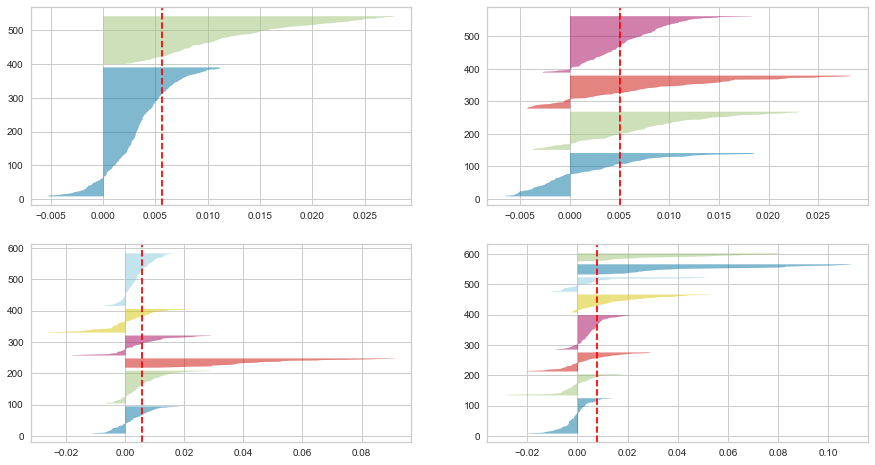

In [75]:
r=0
flag=0
c=0
fig, ax = plt.subplots(2, 2, figsize=(15,8))

for i in [2, 4, 6, 8]:
    true_k = i
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
    labels = model.fit_predict(X)
    #pickle.dump(model, open("kmeans.pkl", "wb"))

    silhouette_avg = silhouette_score(X, labels, metric='euclidean')
    print("For n_clusters =", true_k, "The average silhouette_score is :", silhouette_avg)
 
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[r][c])
    visualizer.fit(X)
    c=1-c
    flag=flag+1
    if flag==2:
        r=r+1
        flag=0
    

For n_clusters = 10 The average silhouette_score is : 0.010273533413307914
r= 0  and c= 0
For n_clusters = 12 The average silhouette_score is : 0.012464962529554547
r= 0  and c= 1
For n_clusters = 14 The average silhouette_score is : 0.008625156276705995
r= 1  and c= 0
For n_clusters = 16 The average silhouette_score is : 0.010548118308406138
r= 1  and c= 1


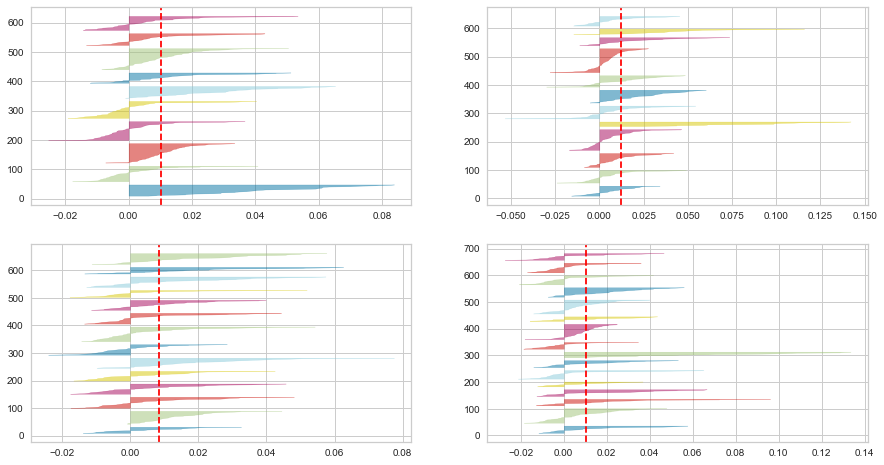

In [77]:
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt

r=0
flag=0
c=0
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [10, 12, 14, 16]:
    true_k = i
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
    labels = model.fit_predict(X)
    #pickle.dump(model, open("kmeans.pkl", "wb"))

    silhouette_avg = silhouette_score(X, labels, metric='euclidean')
    print("For n_clusters =", true_k, "The average silhouette_score is :", silhouette_avg)
    q, mod = divmod(i, 2)
    #print("q=",q," and mod=",mod)
    print("r=",r," and c=",c)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[r][c])
    visualizer.fit(X)
    c=1-c
    flag=flag+1
    if flag==2:
        r=r+1
        flag=0

In [81]:
# train model 
n = 10
model = KMeans(n_clusters=n, init='k-means++', max_iter=100, n_init=1)
model.fit_predict(X)

array([4, 2, 1, 2, 6, 3, 3, 7, 7, 2, 4, 2, 7, 3, 4, 2, 6, 1, 4, 8, 8, 9,
       5, 8, 2, 5, 0, 9, 2, 0, 1, 4, 0, 0, 4, 2, 4, 9, 4, 7, 4, 9, 2, 0,
       3, 1, 8, 8, 1, 9, 6, 6, 2, 2, 2, 1, 9, 3, 2, 6, 6, 2, 1, 3, 1, 4,
       9, 1, 2, 8, 4, 2, 1, 2, 6, 8, 7, 7, 2, 2, 7, 1, 3, 3, 7, 7, 3, 1,
       1, 1, 1, 8, 4, 3, 6, 7, 6, 2, 1, 1, 6, 4, 4, 3, 2, 9, 4, 7, 6, 1,
       3, 1, 3, 4, 3, 1, 8, 4, 4, 7, 8, 6, 4, 1, 6, 7, 3, 0, 6, 4, 4, 7,
       2, 4, 4, 6, 2, 8, 4, 7, 7, 7, 4, 7, 9, 9, 7, 3, 4, 2, 2, 2, 7, 2,
       4, 3, 9, 2, 2, 2, 4, 6, 3, 7, 1, 6, 6, 6, 6, 6, 0, 0, 2, 4, 1, 0,
       4, 1, 0, 6, 0, 0, 0, 9, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 7, 7, 6,
       0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 7, 4, 4, 4, 7, 2, 8,
       0, 2, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 2, 3, 9, 0, 8, 9, 7, 8,
       5, 1, 5, 1, 2, 5, 0, 5, 5, 6, 6, 6, 6, 2, 6, 4, 8, 4, 7, 4, 4, 2,
       6, 8, 9, 8, 4, 4, 5, 1, 2, 5, 5, 5, 5, 5, 1, 5, 5, 2, 1, 5, 5, 1,
       3, 3, 7, 7, 7, 3, 4, 3, 3, 3, 3, 7, 7, 4, 8,

In [82]:
filename = 'kmeans_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [83]:
centroids = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n):
    l = []
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        l.append(terms[ind])
    centroids['cluster ' + str(i)] = l
    
with open('kmeans-centroids.txt', 'w') as outfile:
    json.dump(centroids, outfile)

Cluster 0:
 tcp
 number
 host
 packet
 scanning
 sequence
 port
 syn
 scan
 rst
 udp
 ack
 ping
 firewall
 closed
Cluster 1:
 password
 credential
 update
 address
 identity
 domain
 authentication
 attacks
 dns
 download
 configuration
 registry
 integrity
 mechanism
 account
Cluster 2:
 file
 library
 lock
 load
 log
 buffer
 configuration
 program
 command
 directory
 privilege
 key
 vulnerability
 temporary
 overflow
Cluster 3:
 script
 browser
 site
 remote
 cache
 control
 functionality
 element
 web
 host
 scripting
 message
 page
 local
 website
Cluster 4:
 xml
 query
 error
 field
 message
 sql
 location
 technique
 database
 provider
 injection
 header
 resource
 expected
 return
Cluster 5:
 component
 hardware
 product
 development
 supply
 deployed
 disruption
 compromise
 impact
 chain
 purpose
 logic
 negative
 design
 technology
Cluster 6:
 protocol
 session
 authentication
 perform
 communication
 transaction
 assumption
 impersonate
 gain
 credential
 source
 ticket
 i

In [84]:

ids = []
for i in range(0, n):
    ids.append([])

with open('1000.csv', encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            id = row[0]
            desc = row[4]
            toks = tokenize_and_stem(desc)
            fullstring = ' '.join(toks)
            Y = vectorizer.transform([desc])
            prediction = model.predict(Y)
            ids[prediction[0]].append(id)

Column names are 'ID, Name, Abstraction, Status, Description, Alternate Terms, Likelihood Of Attack, Typical Severity, Related Attack Patterns, Execution Flow, Prerequisites, Skills Required, Resources Required, Indicators, Consequences, Mitigations, Example Instances, Related Weaknesses, Taxonomy Mappings, Notes


In [85]:
cid=0
print("ids of cluster ", cid, "are ", ids[cid])

ids of cluster  0 are  ['125', '128', '285', '287', '292', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '308', '313', '317', '318', '319', '320', '321', '322', '323', '324', '326', '327', '328', '489', '490', '494', '495', '496', '596', '92']


In [96]:
cid=9
print("Cluster:",cid)
filename = "cl"+str(cid)+".txt"
print("filename=", filename)
with open('1000.csv', encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            id = row[0]
            if id in ids[cid]:
                print("ID=",id, " Desc=", row[4])
               

Cluster: 9
filename= cl9.txt
ID= 120  Desc= The adversary utilizes a repeating of the encoding process for a set of characters (that is, character encoding a character encoding of a character) to obfuscate the payload of a particular request. This may allow the adversary to bypass filters that attempt to detect illegal characters or strings, such as those that might be used in traversal or injection attacks. Filters may be able to catch illegal encoded strings, but may not catch doubly encoded strings. For example, a dot (.), often used in path traversal attacks and therefore often blocked by filters, could be URL encoded as %2E. However, many filters recognize this encoding and would still block the request. In a double encoding, the % in the above URL encoding would be encoded again as %25, resulting in %252E which some filters might not catch, but which could still be interpreted as a dot (.) by interpreters on the target.
ID= 135  Desc= An adversary includes formatting characters i